# Download data with Geolabel Maker &nbsp; [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/makinacorpus/geolabel-maker/blob/master/notebooks/Download%20data%20with%20Geolabel%20Maker.ipynb)  

A tutorial provided by [Makina Corpus](https://makina-corpus.com/)

This tutorial will guide you on how to download satellite images from [Sentinel Hub](https://scihub.copernicus.eu/) or [Map Box](https://docs.mapbox.com/api/overview/) API, and retrieve geometries from [Open Street Map](https://overpass-turbo.eu/) in a few lines of code.

This tutorial is divided in three parts:

**1. Download satellite images with `SentinelHub` or `MapBoxAPI`**

**2. Download vector geometries with `OverpassAPI`**

**3. Download a `Dataset` using a configuration file**

## Set Up

As always, we will load the required packages to downlaod data. We will add ``geolabel_maker`` package to the path,
to make sure you can access its modules.  
As this notebook is available on google colaboratory, we need to load GDAL and other packages differently.

In [1]:
import sys
import os

RUN_ON_COLAB = False

# Check if its running from Colab
if "google.colab" in str(get_ipython()):
    RUN_ON_COLAB = True
    print("Running on Google Colab")
else:
    print("Running on Jupyter")

Running on Jupyter


### For Jupyter users

The following code will load packages for Notebook users. Keep in mind that GDAL and other packages must be installed.

In [2]:
if not RUN_ON_COLAB:
    sys.path.append("../")

### For Colab users

In [3]:
if RUN_ON_COLAB:
    # Install GDAL
    !apt install gdal-bin python-gdal python3-gdal 
    # Install rasterio
    !pip install rasterio
    # Install rtree (required by geopandas)
    !apt install python3-rtree 
    # Install geopandas
    !pip install git+git://github.com/geopandas/geopandas.git
    # Install geopandas (required by geopandas)
    !pip install descartes
    # Install GDAL2TILES
    !pip install gdal2tiles
    # Import SentinelSat from ESA Copernicus program
    !pip install sentinelsat
    # OSM to geojson converter
    !pip install osmtogeojson
    # Install OpenCV for fast segmentation
    !pip install opencv-python
    # Install Geolabel Maker
    !git clone -b projinfo-dev https://github.com/makinacorpus/geolabel-maker
    sys.path.append("/content/geolabel-maker")

    # Sanity check to know if GDAL is correctly installed.
    # SKipping this step may raise errors like:
    # CPLE_AppDefinedError: PROJ: proj_create from database: Cannot find proj.db

    import rasterio
    filename = "http://landsat-pds.s3.amazonaws.com/c1/L8/003/065/LC08_L1TP_003065_20190925_20191017_01_T1/LC08_L1TP_003065_20190925_20191017_01_T1_B4.TIF"
    rasterio.open(filename)

### Import the packages

In [4]:
# Basic imports
import matplotlib.pyplot as plt
from getpass import getpass

# Geloabel Maker
from geolabel_maker import Dataset
from geolabel_maker.rasters import Raster, RasterCollection 
from geolabel_maker.vectors import Category, CategoryCollection
from geolabel_maker.downloads import SentinelHubAPI, MapBoxAPI, OverpassAPI

### Speedups

Some users can experience issues related to ``shapely``. To fix it, simply use ``speedups.disable()``

In [5]:
# Disable speedups for windows users because they can experience errors
if os.name == "nt":
    from geolabel_maker import speedups
    
    speedups.disable()

## Download satellite images

First, let's download satellite images.

### Sentinel

To download images from [Sentinel](https://scihub.copernicus.eu/) API, you will need to create an account. You can create one for free, but note that it will be deleted once the 30 days trial will be reached.

We will download images in Paris:

In [6]:
bbox = (4.82, 45.73, 4.87, 45.75)

Then, connect to Sentinel Hub API:

In [7]:
username = getpass("SciHub usernname: ")
password = getpass("SciHub password: ")

SciHub usernname:  ·········
SciHub password:  ···········


In [9]:
api = SentinelHubAPI(username, password)

To download images, you must provide a bounding box ``bbox``. You can also provide optional arguments.

In [14]:
files = api.download(
    bbox,
    date=("20200920", "20201020"),
    platformname="Sentinel-2",
    processinglevel = "Level-2A",
    cloudcoverpercentage=(0, 10),
    bandname="TCI",
    resolution=10,
    out_dir="sentinel"
)

INFO: Downloading 1 satellite image from SentinelHub.
INFO:geolabel_maker:Downloading 1 satellite image from SentinelHub.
Downloading: 100%|████████████████████████████████████████████████████████████████| 1.15G/1.15G [02:44<00:00, 6.99MB/s]
MD5 checksumming: 100%|████████████████████████████████████████████████████████████| 1.15G/1.15G [00:09<00:00, 118MB/s]


#### Cached products

The download process can be a bit long, depending on your connection. One image is usually around a gigabyte, so be patient.
Also, the connection may broke if your internet connection is too weak.

The downloaded elements are ``.zip`` directories containing metadata and a set of images for different resolution.
All these elements are downloaded in a cache folder, with the name of the output directory but starting with a dot: if your output directory is ``sentinel`` then the cache folder wil be ``.sentinel``.

#### Product structure

In this cache folder you will find extracted folders where the names correspond to Sentinel' ids.
For a given directory / product, you will find images in `GRANULE/<PRODUCT>/IMG_DATA`:

```
.sentinel
├── S2A_MSIL2A_20200928T065651_N0214_R063_T39NTC_20200928T092617.SAFE
│   ├── AUX_DATA
│   ├── DATASTRIP
│   ├── GRANULE
│   │   └── L2A_T39NTC_A027516_20200928T071458
│   │       ├── AUX_DATA
│   │       ├── IMG_DATA
│   │       │   ├── R10m
│   │       │   ├── R20m
│   │       │   └── R60m
│   │       ├── QI_DATA
│   │       └── MTD_TL.xml
│   ├── HTML
│   ├── rep_info
│   ├── INSPIRE.xml
│   ├── manifest.safe
│   └── MTD_MSIL2A.xml
└── S2A_MSIL2A_20201008T065801_N0214_R063_T39NTC_20201008T093405.SAFE
    └── ...
```

You can retrieve the metadata directly from the name of an image. For example, `T31TCJ_20190225T105021_B02_10m.jp2`,
the different parts of the name seprated by ``_`` mean:

* `T31TCJ` T + number of the tile
* `20190225T134315`  Date and time of the captured time, in the format: aaammjjThhmmss
* `B02` Band (see the details of the bands below)
* `10m` Resolution

Details of the images availble:

* R10m:
    * `T31TCJ_20190225T105021_B02_10m.jp2`: blue
    * `T31TCJ_20190225T105021_B03_10m.jp2`: green
    * `T31TCJ_20190225T105021_B04_10m.jp2`: red
    * `T31TCJ_20190225T105021_TCI_10m.jp2`: true color image
    * `T31TCJ_20190225T105021_B08_10m.jp2`: NIR  = near infrared (vegetation discrimination)
    * `T31TCJ_20190225T105021_WVP_10m.jp2`: water vapour
    * `T31TCJ_20190225T105021_AOT_10m.jp2`: top-of-atmosphere
    
* R20m:
    * `T31TCJ_20190225T105021_B03_20m.jp2`: green
    * `T31TCJ_20190225T105021_B8A_20m.jp2`: NIR ~860nm (vegetation discrimination)
    * `T31TCJ_20190225T105021_SCL_20m.jp2`: scene classification map**
    * `T31TCJ_20190225T105021_TCI_20m.jp2`: true color image
    * `T31TCJ_20190225T105021_WVP_20m.jp2`: water vapour
    * `T31TCJ_20190225T105021_B12_20m.jp2`: SWIR ~2200nm (snow/ice/cloud discrimination)
    * `T31TCJ_20190225T105021_B04_20m.jp2`: red
    * `T31TCJ_20190225T105021_B02_20m.jp2`: blue
    * `T31TCJ_20190225T105021_B06_20m.jp2`: NIR ~750nm (vegetation discrimination)
    * `T31TCJ_20190225T105021_AOT_20m.jp2`: top-of-atmosphere
    * `T31TCJ_20190225T105021_B07_20m.jp2`: NIR ~775nm (vegetation discrimination)
    * `T31TCJ_20190225T105021_B05_20m.jp2`: NIR ~700nm (vegetation discrimination)
    * `T31TCJ_20190225T105021_B11_20m.jp2`: SWIR ~1600nm (snow/ice/cloud discrimination)

* R60m:
    * `T31TCJ_20190225T105021_B03_60m.jp2`: green
    * `T31TCJ_20190225T105021_B04_60m.jp2`: red
    * `T31TCJ_20190225T105021_B11_60m.jp2`: SWIR ~1600nm (snow/ice/cloud discrimination)
    * `T31TCJ_20190225T105021_B05_60m.jp2`: NIR ~700nm (vegetation discrimination)
    * `T31TCJ_20190225T105021_B12_60m.jp2`: SWIR ~2200nm (snow/ice/cloud discrimination)
    * `T31TCJ_20190225T105021_WVP_60m.jp2`: water vapour
    * `T31TCJ_20190225T105021_B01_60m.jp2`: blue ~450nm (aerosols discrimination)
    * `T31TCJ_20190225T105021_SCL_60m.jp2`: scene classification map
    * `T31TCJ_20190225T105021_AOT_60m.jp2`: top-of-atmosphere
    * `T31TCJ_20190225T105021_B07_60m.jp2`: NIR ~775nm (vegetation discrimination)
    * `T31TCJ_20190225T105021_B06_60m.jp2`: NIR ~750nm (vegetation discrimination)
    * `T31TCJ_20190225T105021_B09_60m.jp2`: NIR ~840nm (water vapour discrimination)
    * `T31TCJ_20190225T105021_TCI_60m.jp2`: true color image
    * `T31TCJ_20190225T105021_B02_60m.jp2`: blue
    * `T31TCJ_20190225T105021_B8A_60m.jp2`: NIR ~860nm (vegetation discrimination)
 
 
 
** scene classification map is a classification map which includes four different classes for clouds (including cirrus) and six different classifications for shadows, cloud shadows, vegetation, soils/deserts, water and snow.


#### Retrieved images

The output directory will only contains the images of the specified ``bandname`` and ``resolution``. By defaults they are set to ``TCI`` (True Color) and ``10`` respectively.

The outout directory should be:

```
./
├── sentinel
│   ├── T39NTC_20200928T065651_TCI_10m.jp2
│   └── T39NTC_20201008T065801_TCI_10m.jp2
└── .sentinel
    ├── S2A_MSIL2A_20200928T065651_N0214_R063_T39NTC_20200928T092617.SAFE
    │   └── ...
    └── S2A_MSIL2A_20201008T065801_N0214_R063_T39NTC_20201008T093405.SAFE
        └── ...
```

In [15]:
files

['sentinel\\T38NNL_20201016T070859_TCI_10m.jp2']

### MapBox

Another famous platform that provides satellite imagery is [MapBox](https://www.mapbox.com/). However, the images are static and you can't request a tile for a specific date.

You need an user account. Then, you must provide your access token to use the API.

In [16]:
bbox = (4.82, 45.73, 4.87, 45.75)

In [19]:
# access_token = pk.[...]
access_token = getpass("MapBox token: ")

MapBox token:  ····························································································


In [20]:
api = MapBoxAPI(access_token)

In [21]:
files = api.download(
    bbox, 
    zoom=17, 
    high_res=True,      
    slippy_maps=False,   
    width=10_240,       
    height=10_240,      
    out_dir="mapbox",   
    out_format="tif"    
)

INFO: Downloading 220 satellite images from MapBox.
INFO:geolabel_maker:Downloading 220 satellite images from MapBox.
Downloading: 100%|███████████████████████████████████████████████████████████████████| 220/220 [01:07<00:00,  1.74it/s]

In [22]:
files

['mapbox\\MAPBOX_MOSAIC_17_67309_46771.tif']

Note that the coordinate of the downloaded rasters are in the geographic system.

## Download vector geometries

The next step is to retrieve geometries in a vector format. [Open Street Map](https://www.openstreetmap.org) is an open access platform for geodata. You can download roads, buildings, vegetation area (and more) in a vector (``json`` or ``osm`` format).

### Open Street Map

You can download geometries directly from [Open Street Map website](https://www.openstreetmap.org). Once connected, click on ``Export`` button. You will be redirected to a [map](https://www.openstreetmap.org/export#map=10/48.8710/2.4142), centered near your position. Drag and drop the map to change the location. You can select an area to download with the ``Manually select a different area`` button under the bounding box, located in the left panel. To download (all) the data, click on the blue ``Export`` button on the left panel.

### Overpass API

Alternatively, you can connect to OSM API to retrieve lattest geometries. You can directly connect to ``openstreetmap`` and make your request, or use the ``overpass`` server used to retrieve larger area. In this notebook, we will use the Overpass API.

#### Connect

You don't need an account to download geometries from Open Street Map. However you will be limited on the size of requested data.

In [23]:
api = OverpassAPI()

#### Download

The response of a query is not in ``geosjon`` format. Geolabel Maker will convert it for you. If you somehow wish to do it manually, you can install ``osmtogeojson`` which does exactly this step. You can also use ``GDAL`` and the command ``ogr2ogr``.

Using the ``OverpassAPI`` from Geolabel Maker, you can download specific categories of vectors. The ``selector`` argument follow [Open Street Map Query](https://wiki.openstreetmap.org/wiki/Map_features) syntax to retrieve geometries of the same instance.

Example of ``selector``:

```
selector = "key"
selector = "key=value"
```

Example:

```python
selector = "building"
selector = "building=hotel"

selector = "natural"
selector = "natural=wood"
```

In [31]:
bbox = (4.82, 45.73, 4.87, 45.75)

In [27]:
# Download all buildings geometries
file_buildings = api.download(
    bbox, 
    selector="building", 
    timeout=700, 
    out_file="buildings.json"
)

# Download all parkings geometries
file_woods = api.download(
    bbox, 
    selector="natural=wood", 
    timeout=700, 
    out_file="woods.json"
)

INFO: Downloading building from Overpass.
INFO:geolabel_maker:Downloading building from Overpass.
INFO: Downloading wood (natural) from Overpass.
INFO:geolabel_maker:Downloading wood (natural) from Overpass.


You can now load the files with ``Category`` or ``CategoryCollection`` class.

In [28]:
buildings = Category.open(file_buildings, color="grey")
woods = Category.open(file_woods, color="green")

In [29]:
categories = CategoryCollection(buildings, woods)
categories

CategoryCollection(
  (0): Category(filename='buildings.json', data=GeoDataFrame(6750 rows, 2 columns), name='buildings', color=(128, 128, 128), crs=EPSG:4326)
  (1): Category(filename='woods.json', data=GeoDataFrame(2 rows, 2 columns), name='woods', color=(0, 128, 0), crs=EPSG:4326)
)

<AxesSubplot:title={'center':'CategoryCollection'}>

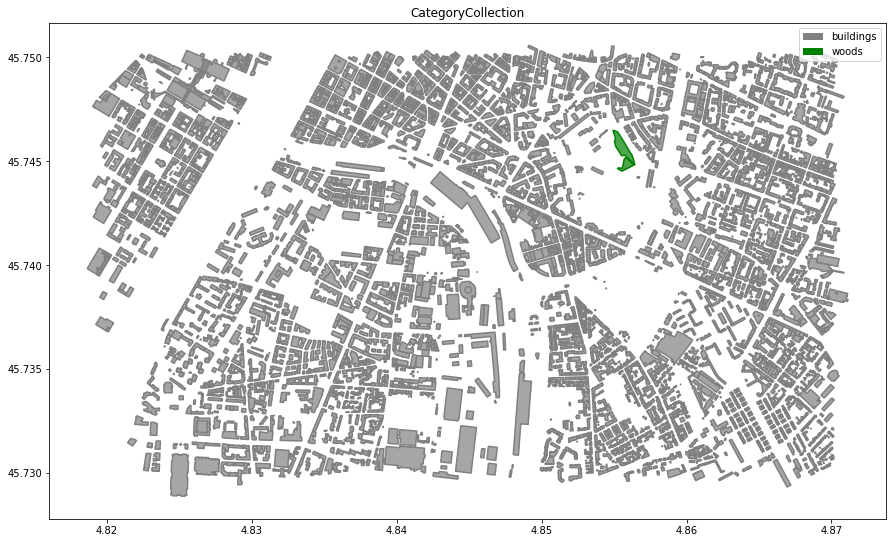

In [30]:
categories.plot(figsize=(15, 15))

If you load the files using the ``CategoryCollection``, colors will be randomly generated.

## Download using a dataset

Last but not least, you can download the above data using a configuration file and a ``Dataset``.
You will need to give all the arguments used in the differents APIs in a ``JSON`` file as:

```json
{
    "dir_images": "images",
    "dir_categories": "categories",
    "bbox": [4.82, 45.73, 4.87, 45.75],
    "sentinelhub": {
        "username": "...",
        "password": "...",
        "date": ["20200920", "20201020"],
        "platformname": "Sentinel-2",
        "processinglevel": "Level-2A",
        "cloudcoverpercentage": [0, 10],
        "bandname": "TCI",
        "resolution": 10
    },
    "mapbox": {
        "access_token": "pk...",
        "zoom": 17, 
        "high_res": true,
        "slippy_maps": false,
        "width": 10240,       
        "height": 10240,   
    },
    "overpass": {
        "geometries": [
            {
                "selector": "building",
                "name": "buildings"
            },
            {
                "selector": "natural=wood",
                "name": "woods"
            }
        ]
    }
} 
```

In [ ]:
dataset = Dataset.download("config.json")